<h2> Automatic filtering </h2> 

In [1]:
# import packages
import csv
import pandas as pd
import re
from bs4 import BeautifulSoup
import requests
import os
import numpy as np
import string
import math
from nltk import ngrams
import PyPDF2
import json
import time
import seaborn as sns
from matplotlib import pyplot as plt
import shutil
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.tokenize import PunktSentenceTokenizer

In [2]:
# import internal modules
import file_path_management as fpath
import public_library as plib
import extract_info
import parameters as params
import download_and_process_pdf as dpp
import dataframe_columns as df_col

2023-10-09 13:08:49 GM01X680 metapub.config[349754] WARNING NCBI_API_KEY was not set.


<h3> Predefined fucntions: </h3> 

In [41]:
def count_word_from_text(text, word): 
    word = word.lower()

    # process text
    text = plib.process_text(text, lower=True)

    tokens = word_tokenize(text)

    len_word = len(word.split())
    
    # get the words of length len_word from text
    ng = list(ngrams(tokens, len_word))
    words = [' '.join(gram) for gram in ng]
    # print(words)

    # count word
    if word in params.exact_match_kw_list: # if word is in exact_match_kw_list, use exact match
        count = 0
        for w in words:
            if word == w:
                count += 1
    else: # if word is not in exact_match_kw_list, use fuzzy match
        count = text.count(word)
    return count
# --------------------Start of test code--------------------
# # text = 'This all.6 apple 6i7s very_tasty？、 apple, 6i7s 2but-the banana this is not delicious at Is all.6'
# # text = "cat of the dopcate innervaton in innervation the macaque and human thalamus Miguel Ángel García-Cabezas,aBeatriz Rico,a,b Miguel Ángel Sánchez-González,aand Carmen Cavadaa,⁎ aDepartamento de Anatomía, Histología y Neurociencia, Facultad de Medicina, Universidad Autónoma de Madrid, C/Arzobispo Morcillo s/n, 28029 Madrid, Spain bInstituto de Neurociencias de Alicante, Universidad Miguel Hernández-CSIC, 03550 Sant Joan d ’Alacant, Spain Received 19 April 2006; revised 8 June 2006; accepted 11 July 2006 Available online 30 November 2006 We recently defined the thalamic dopaminergic system in primates; it arises from numerous dopaminergic cell groups and selectively targetsnumerous thalamic nuclei. Given the central position of the thalamus in subcortical and cortical interplay, and the functional relevance of dopamine neuromodulation in the brain, detailing dopamine dis-tribution in the thalamus should supply important information. Tothis end we performed immunohistochemistry for dopamine and the dopamine transporter in the thalamus of macaque monkeys and humans to generate maps, in the stereotaxic coronal plane, of thedistribution of dopaminergic axons. The dopamine innervation of the thalamus follows the same pattern in both species and is most dense in midline limbic nuclei, the mediodorsal and lateral posteriorassociation nuclei, and in the ventral lateral and ventral anteriormotor nuclei. This distribution suggests that thalamic dopamine has a prominent role in emotion, attention, cognition and complex somatosensory and visual processing, as well as in motor control.Most thalamic dopaminergic axons are thin and varicose and targetboth the neuropil and small blood vessels, suggesting that, besides neuronal modulation, thalamic dopamine may have a direct influence on microcirculation. The maps provided here should be a usefulreference in future experimental and neuroimaging studies aiming atclarifying the role of the thalamic dopaminergic system in health and in conditions involving brain dopamine, including Parkinson ’s disease, drug addiction and schizophrenia.© 2006 Elsevier Inc. All rights reserved. Keywords: Dopamine; Thalamus; Monkey; Human; Primate; Dopamine transporter; Parkinson; Schizophrenia; AddictionIntroduction The thalamus is made up of multiple nuclei relaying information from subcortical centers or from other cortices to the cerebral cortex (Sherman and Guillery, 2005 ), as well as the striatum, the nucleus accumbens and the amygdala ( Steriade et al., 1997 ). In addition to specific subcortical and cortical afferents, the primate thalamus receives axons containing the neuromodulators acetylcholine (Heckers et al., 1992 ), histamine ( Manning et al., 1996 ), serotonin (Morrison and Foote, 1986; Lavoie and Parent, 1991 ), and the catecholamines adrenaline ( Rico and Cavada, 1998a ), noradrenaline (Morrison and Foote, 1986; Ginsberg et al., 1993 ) and dopamine (Sánchez-González et al., 2005 ). Until recently, the existence of significant dopamine innervation in the primate thalamus has been largely ignored, probably becausedopamine innervation of the rodent thalamus is very scant(Groenewegen, 1988; Papadopoulos and Parnavelas, 1990 ). However, fragmentary data scattered through the literature endorse the presence of dopamine innervation in the primate thalamus.Postmortem biochemical studies showed the presence of dopamine in the thalamus of macaques ( Brown et al., 1979; Goldman-Rakic and Brown, 1981; Pifl et al., 1990, 1991 ) and human subjects ( Oke and Adams, 1987 ). Later, receptor binding and in situ hybridization analyses detected the presence of dopamine D2-like ( Joyce et al., 1991; Kessler et al., 1993; Hall et al., 1996; Langer et al., 1999;Rieck et al., 2004 ) and D3-like receptors ( Gurevich and Joyce, 1999 ) in several human thalamic nuclei. Positron emission tomography (PET) radioligand studies have also demonstratedthe presence of the dopamine transporter (DAT) ( Wang et al., 1995; Halldin et al., 1996; Helfenbein et al., 1999; Brownell et al., 2003 ) and of D2-like receptors ( Farde et al., 1997; Langer et al., 1999; Okubo et al., 1999; Brownell et al., 2003; Rieck et al., 2004 ) in the human and macaque thalamus. In the course of PET studies focusing on schizophrenia, D2- and D3-like radioligand binding was also found in the thalamus of control subjects ( Talvik et al., 2003; Yasuno et al., 2004 ). Finally, an immunohistochemical study using anti-DAT antibodies detected the presence of dopaminergic www.elsevier.com/locate/ynimg NeuroImage 34 (2007) 965 –984 ⁎Corresponding author. Fax: +34 91 497 53 15. E-mail address: carmen.cavada@uam.es (C. Cavada). Available online on ScienceDirect (www.sciencedirect.com). 1053-8119/$ - see front matter © 2006 Elsevier Inc. All rights reserved. doi:10.1016/j.neuroimage.2006.07.032"
# text = "Effect of sCate Attentive  ca t Fixation in Macaque asThalamusss andc Cortexs D. B. BENDER AND M. YOUAKIM Department of Physiology and Biophysics, School of Medicine and Biomedical Sciences, University at Buffalo, State University of New York, Buffalo, New York 14214 Received 29 December 1999; accepted in final form 21 September 2000 Bender, D. B. and M. Youakim. Effect of attentive fixation in macaque thalamus and cortex. J Neurophysiol 85: 219234, 2001. Attentional modulation of neuronal responsiveness is common in many areas of visual cortex. We examined whether attentional modulation in the visual thalamus was quantitatively similar to that in cortex. Identical procedures and apparatus were used to compare attentional modulation of single neurons in seven different areas of the visual system: the lateral geniculate, three visual subdivisions of the pulvinar [inferior, lateral, dorsomedial part of lateral pulvinar (Pdm)], and three areas of extrastriate cortex representing early, intermediate, and late stages of cortical processing (V2, V4/PM, area 7a). A simple fixation task controlled transitions among three attentive states. The animal waited for a fixation point to appear (ready state), fixated the point until it dimmed (fixation state), and then waited idly to begin the next trial (idle state). Attentional modulation was estimated by flashing an identical, irrelevant stimulus in a neurons receptive field during each of the three states; the three responses defined a response vector whose deviation from the line of equal response in all three states (the main diagonal) indicated the character and magnitude of attentional modulation. Attentional modulation was present in all visual areas except the lateral geniculate, indicating that modulation was of central origin. Prevalence of modulation was modest (26%) in pulvinar, and increased from 21% in V2 to 43% in 7a. Modulation had a push-pull character (as many cells facilitated as suppressed) with respect to the fixation state in all areas except Pdm where all cells were suppressed during fixation. The absolute magnitude of attentional modulation, measured by the angle between response vector and main diagonal expressed as a percent of the maximum possible angle, differed among brain areas. Magnitude of modulation was modest in the pulvinar (1926%), and increased from 22% in V2 to 41% in 7a. However, average trial-to-trial variability of response, measured by the coefficient of variation, also increased across brain areas so that its difference among areas accounted for more than 90% of the difference in modulation magnitude among areas. We also measured attentional modulation by the ratio of cell discharge due to attention divided by discharge variability. The resulting signal-tonoise ratio of attention was small and constant, 1.3 6 10%, across all areas of pulvinar and cortex. We conclude that the pulvinar, but not the lateral geniculate, is as strongly affected by attentional state as any area of visual cortex we studied and that attentional modulation amplitude is closely tied to intrinsic variability of response. INTRODUCTION It is now clear that attention can affect the responsiveness of neurons throughout visual cortex. Visually responsive cortex includes a number of distinct areas beyond striate cortex, or V1. Beginning with V2, these extrastriate areas are organized into two partially segregated, roughly hierarchical systems (reviews in Felleman and Van Essen 1991; Maunsell and Newsome 1987; Ungerleider and Mishkin 1982; Van Essen 1985). One includes dorsally located areas such as V3A, MT, and MST and leads into area 7a in the inferior parietal lobule. The other includes more ventrally located areas such as V4 and TEO and leads into area TE in the temporal lobe. Recordings from single neurons in many of these areas show that neuronal excitability depends on the animals attentive state (reviews in Colby 1991; Desimone and Duncan 1995; Lock and Bender 1999; Maunsell 1995; Motter 1998). Typically the effect of attention is modest: a small increase or decrease in magnitude of response to a visual stimulus relative to a control condition. Such modulation can be found at virtually every level of the cortical hierarchy, including V1. A variety of behavioral paradigms have been used to manipulate attention, and these show that the prevalence and magnitude of attentional modulation can depend substantially on both the behavioral paradigm and the cortical area in which its effects are measured. Furthermore factors such as task difficulty, the extent to which a task engages the functions of an area, and whether multiple stimuli compete for attention all can affect the modulation (Luck et al. 1997; Motter 1993; Richmond and Sato 1987). To what extent does the thalamus contribute to, or participate in, the attentional modulation that is so widespread throughout visual cortex? Three thalamic nuclei are closely interrelated with visual cortex: the lateral geniculate nucleus, the pulvinar, and the reticular nucleus of the thalamus. All have been thought to be involved in one form of attention or another (e.g., Guillery et al. 1998; Koch and Ullman 1985; Olshausen et al. 1993). The lateral geniculate projects almost exclusively to V1 with little or no output to extrastriate cortex. Layer 6 of both extrastriate and striate cortex project back to the geniculate, potentially modulating transmission through it. The pulvinar has at least three distinct visual subdivisions. The inferior (PI) and lateral pulvinar (PL) contain two separate visuotopic maps (Bender 1981). PI is driven by input from V1 (Bender 1983) but also receives input from extrastriate cortex and the superior colliculus. It projects mainly to V2, V3, V3A, and MT. PL likewise receives input from V1 and extrastriate cortex, but may have a particular affinity"
# keyword = 'sThalamusss andc cortex'
# count = count_word_from_text(text, keyword)
# print(count)
# ---------------------End of test code---------------------

1


In [47]:
def count_kw_group_from_text(text_tak, text_txt, keyword_group):
    if text_txt == text_txt and text_txt != "": # if full text is available, use full text
        text = text_txt
    elif text_tak == text_tak and text_tak != "": # if full text is not available, use tak (title + abstract + keywords)
        text = text_tak
    else:
        raise ValueError('text_tak and text_txt cannot both be np.nan.')

    # process the text
    text = plib.process_text(text, lower=True)

    # count the number of keywords
    word_count = 0
    for word in keyword_group:
        word_count += count_word_from_text(text, word)

    return word_count
# --------------------start of test code--------------------
# text_tak = 'Virhesussiorhesuscat macaqua Cat Rhesus fRhesusor rhesus action: thalamic and cortical inputs to the macaque superior tract neural tracing, parietal lobule The dorsal visual stream, the cortical circuit that in the primate brain is mainly dedicated to the visual control of actions, is split into two routes, a lateral and a medial one, both involved in coding different aspects of sensorimotor control of actions. The lateral route, named "lateral grasping network", is mainly involved in the control of the distal part of prehension, namely grasping and manipulation. The medial route, named "reach-to-grasp network", is involved in the control of the full deployment of prehension act, from the direction of arm movement to the shaping of the hand according to the object to be grasped. In macaque monkeys, the reach-to-grasp network (the target of this review) includes areas of the superior parietal lobule (SPL) that hosts visual and somatosensory neurons well suited to control goal-directed limb movements toward stationary as well as moving objects. After a brief summary of the neuronal functional properties of these areas, we will analyze their cortical and thalamic inputs thanks to retrograde neuronal tracers separately injected into the SPL areas V6, V6A, PEc, and PE. These areas receive visual and somatosensory information distributed in a caudorostral, visuosomatic trend, and some of them are directly connected with the dorsal premotor cortex. This review is particularly focused on the origin and type of visual information reaching the SPL, and on the functional role this information can play in guiding limb interaction with objects in structured and dynamic environments. Area PEc; Area V6; Area V6A; Dorsal visual stream; Goal-directed arm movement; Sensorimotor integration.'
# # text_txt = "rhesusSDistrirhesusbution rhesus of the dopamine innervation in the macaque and human thalamus Miguel Ángel García-Cabezas,aBeatriz Rico,a,b Miguel Ángel Sánchez-González,aand Carmen Cavadaa,⁎ aDepartamento de Anatomía, Histología y Neurociencia, Facultad de Medicina, Universidad Autónoma de Madrid, C/Arzobispo Morcillo s/n, 28029 Madrid, Spain bInstituto de Neurociencias de Alicante, Universidad Miguel Hernández-CSIC, 03550 Sant Joan d ’Alacant, Spain Received 19 April 2006; revised 8 June 2006; accepted 11 July 2006 Available online 30 November 2006 We recently defined the thalamic dopaminergic system in primates; it arises from numerous dopaminergic cell groups and selectively targetsnumerous thalamic nuclei. Given the central position of the thalamus in subcortical and cortical interplay, and the functional relevance of dopamine neuromodulation in the brain, detailing dopamine dis-tribution in the thalamus should supply important information. Tothis end we performed immunohistochemistry for dopamine and the dopamine transporter in the thalamus of macaque monkeys and humans to generate maps, in the stereotaxic coronal plane, of thedistribution of dopaminergic axons. The dopamine innervation of the thalamus follows the same pattern in both species and is most dense in midline limbic nuclei, the mediodorsal and lateral posteriorassociation nuclei, and in the ventral lateral and ventral anteriormotor nuclei. This distribution suggests that thalamic dopamine has a prominent role in emotion, attention, cognition and complex somatosensory and visual processing, as well as in motor control.Most thalamic dopaminergic axons are thin and varicose and targetboth the neuropil and small blood vessels, suggesting that, besides neuronal modulation, thalamic dopamine may have a direct influence on microcirculation. The maps provided here should be a usefulreference in future experimental and neuroimaging studies aiming atclarifying the role of the thalamic dopaminergic system in health and in conditions involving brain dopamine, including Parkinson ’s disease, drug addiction and schizophrenia.© 2006 Elsevier Inc. All rights reserved. Keywords: Dopamine; Thalamus; Monkey; Human; Primate; Dopamine transporter; Parkinson; Schizophrenia; AddictionIntroduction The thalamus is made up of multiple nuclei relaying information from subcortical centers or from other cortices to the cerebral cortex (Sherman and Guillery, 2005 ), as well as the striatum, the nucleus accumbens and the amygdala ( Steriade et al., 1997 ). In addition to specific subcortical and cortical afferents, the primate thalamus receives axons containing the neuromodulators acetylcholine (Heckers et al., 1992 ), histamine ( Manning et al., 1996 ), serotonin (Morrison and Foote, 1986; Lavoie and Parent, 1991 ), and the catecholamines adrenaline ( Rico and Cavada, 1998a ), noradrenaline (Morrison and Foote, 1986; Ginsberg et al., 1993 ) and dopamine (Sánchez-González et al., 2005 ). Until recently, the existence of significant dopamine innervation in the primate thalamus has been largely ignored, probably becausedopamine innervation of the rodent thalamus is very scant(Groenewegen, 1988; Papadopoulos and Parnavelas, 1990 ). However, fragmentary data scattered through the literature endorse the presence of dopamine innervation in the primate thalamus.Postmortem biochemical studies showed the presence of dopamine in the thalamus of macaques ( Brown et al., 1979; Goldman-Rakic and Brown, 1981; Pifl et al., 1990, 1991 ) and human subjects ( Oke and Adams, 1987 ). Later, receptor binding and in situ hybridization analyses detected the presence of dopamine D2-like ( Joyce et al., 1991; Kessler et al., 1993; Hall et al., 1996; Langer et al., 1999;Rieck et al., 2004 ) and D3-like receptors ( Gurevich and Joyce, 1999 ) in several human thalamic nuclei. Positron emission tomography (PET) radioligand studies have also demonstratedthe presence of the dopamine transporter (DAT) ( Wang et al., 1995; Halldin et al., 1996; Helfenbein et al., 1999; Brownell et al., 2003 ) and of D2-like receptors ( Farde et al., 1997; Langer et al., 1999; Okubo et al., 1999; Brownell et al., 2003; Rieck et al., 2004 ) in the human and macaque thalamus. In the course of PET studies focusing on schizophrenia, D2- and D3-like radioligand binding was also found in the thalamus of control subjects ( Talvik et al., 2003; Yasuno et al., 2004 ). Finally, an immunohistochemical study using anti-DAT antibodies detected the presence of dopaminergic www.elsevier.com/locate/ynimg NeuroImage 34 (2007) 965 –984 ⁎Corresponding author. Fax: +34 91 497 53 15. E-mail address: carmen.cavada@uam.es (C. Cavada). Available online on ScienceDirect (www.sciencedirect.com). 1053-8119/$ - see front matter © 2006 Elsevier Inc. All rights reserved. doi:10.1016/j.neuroimage.2006.07.032"
# text_txt = "Effect of cats Attentive Fixation in Macaque Thalamus and Cortex D. B. BENDER AND M. YOUAKIM Department of Physiology and Biophysics, School of Medicine and Biomedical Sciences, University at Buffalo, State University of New York, Buffalo, New York 14214 Received 29 December 1999; accepted in final form 21 September 2000 Bender, D. B. and M. Youakim. Effect of attentive fixation in macaque thalamus and cortex. J Neurophysiol 85: 219234, 2001. Attentional modulation of neuronal responsiveness is common in many areas of visual cortex. We examined whether attentional modulation in the visual thalamus was quantitatively similar to that in cortex. Identical procedures and apparatus were used to compare attentional modulation of single neurons in seven different areas of the visual system: the lateral geniculate, three visual subdivisions of the pulvinar [inferior, lateral, dorsomedial part of lateral pulvinar (Pdm)], and three areas of extrastriate cortex representing early, intermediate, and late stages of cortical processing (V2, V4/PM, area 7a). A simple fixation task controlled transitions among three attentive states. The animal waited for a fixation point to appear (ready state), fixated the point until it dimmed (fixation state), and then waited idly to begin the next trial (idle state). Attentional modulation was estimated by flashing an identical, irrelevant stimulus in a neurons receptive field during each of the three states; the three responses defined a response vector whose deviation from the line of equal response in all three states (the main diagonal) indicated the character and magnitude of attentional modulation. Attentional modulation was present in all visual areas except the lateral geniculate, indicating that modulation was of central origin. Prevalence of modulation was modest (26%) in pulvinar, and increased from 21% in V2 to 43% in 7a. Modulation had a push-pull character (as many cells facilitated as suppressed) with respect to the fixation state in all areas except Pdm where all cells were suppressed during fixation. The absolute magnitude of attentional modulation, measured by the angle between response vector and main diagonal expressed as a percent of the maximum possible angle, differed among brain areas. Magnitude of modulation was modest in the pulvinar (1926%), and increased from 22% in V2 to 41% in 7a. However, average trial-to-trial variability of response, measured by the coefficient of variation, also increased across brain areas so that its difference among areas accounted for more than 90% of the difference in modulation magnitude among areas. We also measured attentional modulation by the ratio of cell discharge due to attention divided by discharge variability. The resulting signal-tonoise ratio of attention was small and constant, 1.3 6 10%, across all areas of pulvinar and cortex. We conclude that the pulvinar, but not the lateral geniculate, is as strongly affected by attentional state as any area of visual cortex we studied and that attentional modulation amplitude is closely tied to intrinsic variability of response. INTRODUCTION It is now clear that attention can affect the responsiveness of neurons throughout visual cortex. Visually responsive cortex includes a number of distinct areas beyond striate cortex, or V1. Beginning with V2, these extrastriate areas are organized into two partially segregated, roughly hierarchical systems (reviews in Felleman and Van Essen 1991; Maunsell and Newsome 1987; Ungerleider and Mishkin 1982; Van Essen 1985). One includes dorsally located areas such as V3A, MT, and MST and leads into area 7a in the inferior parietal lobule. The other includes more ventrally located areas such as V4 and TEO and leads into area TE in the temporal lobe. Recordings from single neurons in many of these areas show that neuronal excitability depends on the animals attentive state (reviews in Colby 1991; Desimone and Duncan 1995; Lock and Bender 1999; Maunsell 1995; Motter 1998). Typically the effect of attention is modest: a small increase or decrease in magnitude of response to a visual stimulus relative to a control condition. Such modulation can be found at virtually every level of the cortical hierarchy, including V1. A variety of behavioral paradigms have been used to manipulate attention, and these show that the prevalence and magnitude of attentional modulation can depend substantially on both the behavioral paradigm and the cortical area in which its effects are measured. Furthermore factors such as task difficulty, the extent to which a task engages the functions of an area, and whether multiple stimuli compete for attention all can affect the modulation (Luck et al. 1997; Motter 1993; Richmond and Sato 1987). To what extent does the thalamus contribute to, or participate in, the attentional modulation that is so widespread throughout visual cortex? Three thalamic nuclei are closely interrelated with visual cortex: the lateral geniculate nucleus, the pulvinar, and the reticular nucleus of the thalamus. All have been thought to be involved in one form of attention or another (e.g., Guillery et al. 1998; Koch and Ullman 1985; Olshausen et al. 1993). The lateral geniculate projects almost exclusively to V1 with little or no output to extrastriate cortex. Layer 6 of both extrastriate and striate cortex project back to the geniculate, potentially modulating transmission through it. The pulvinar has at least three distinct visual subdivisions. The inferior (PI) and lateral pulvinar (PL) contain two separate visuotopic maps (Bender 1981). PI is driven by input from V1 (Bender 1983) but also receives input from extrastriate cortex and the superior colliculus. It projects mainly to V2, V3, V3A, and MT. PL likewise receives input from V1 and extrastriate cortex, but may have a particular affinity"
# keyword_group = ['cat', 'macaque Thalamus', 'macaca']
# keywords_count = count_kw_group_from_text(text_tak, text_txt, keyword_group)
# print(keywords_count)
# ---------------------end of test code---------------------

2


In [92]:
def extract_sent_from_text(text, kw_group):
    text = plib.process_text(text, lower=True) 
    sents = []

    all_sentences = sent_tokenize(text)
    # print the sentences
    # for sent in all_sentences:
    #     print(sent)

    for sent in all_sentences:
        flag = False # this sentence is not found
        if not sent.endswith('.'):
            sent += '.'
        # print(sent)
        # print(sent)
        for keyword in kw_group:
            keyword = keyword.lower()
            # print(keyword)
            # If the keyword is in exact match keyword list, then the keyword must be matched exactly
            if keyword in params.exact_match_kw_list:
                words = word_tokenize(sent)
                print(words)
                for word in words:
                    if word == keyword and sent not in sents:
                        sents.append(sent)
                        flag = True
                        break
                if flag:
                    break
            # If the keyword is not in exact match keyword list, then the keyword can be matched in a word
            elif (keyword not in params.exact_match_kw_list) and (keyword in sent) and (sent not in sents):
                sents.append(sent)
                # print(sents)
                break
            else:
                continue
    
    # print(list(sents))
    # convert set to string
    sents = ' '.join(sent for sent in sents)
    sents = sents.strip()

    return sents
# --------------------Start of test code--------------------
# text = "Effect of scat Attentive Fixation sin acaques shalamus and Cortex. D. B. BENDER AND M. YOUAKIM Department of Physiology and Biophysics, School of Medicine and Biomedical Sciences, University at Buffalo, State University of New York, Buffalo, New York 14214 Received 29 December 1999; accepted in final form 21 September 2000 Bender, D. B. and M. Youakim. Effect of attentive fixation in macaque thalamus and cortex. J Neurophysiol 85: 219234, 2001. Attentional modulation of neuronal responsiveness is common in many areas of visual cortex. We examined whether attentional modulation in the visual thalamus was quantitatively similar to that in cortex. Identical procedures and apparatus were used to compare attentional modulation of single neurons in seven different areas of the visual system: the lateral geniculate, three visual subdivisions of the pulvinar [inferior, lateral, dorsomedial part of lateral pulvinar (Pdm)], and three areas of extrastriate cortex representing early, intermediate, and late stages of cortical processing (V2, V4/PM, area 7a). A simple fixation task controlled transitions among three attentive states. The animal waited for a fixation point to appear (ready state), fixated the point until it dimmed (fixation state), and then waited idly to begin the next trial (idle state). Attentional modulation was estimated by flashing an identical, irrelevant stimulus in a neurons receptive field during each of the three states; the three responses defined a response vector whose deviation from the line of equal response in all three states (the main diagonal) indicated the character and magnitude of attentional modulation. Attentional modulation was present in all visual areas except the lateral geniculate, indicating that modulation was of central origin. Prevalence of modulation was modest (26%) in pulvinar, and increased from 21% in V2 to 43% in 7a. Modulation had a push-pull character (as many cells facilitated as suppressed) with respect to the fixation state in all areas except Pdm where all cells were suppressed during fixation. The absolute magnitude of attentional modulation, measured by the angle between response vector and main diagonal expressed as a percent of the maximum possible angle, differed among brain areas. Magnitude of modulation was modest in the pulvinar (1926%), and increased from 22% in V2 to 41% in 7a. However, average trial-to-trial variability of response, measured by the coefficient of variation, also increased across brain areas so that its difference among areas accounted for more than 90% of the difference in modulation magnitude among areas. We also measured attentional modulation by the ratio of cell discharge due to attention divided by discharge variability. The resulting signal-tonoise ratio of attention was small and constant, 1.3 6 10%, across all areas of pulvinar and cortex. We conclude that the pulvinar, but not the lateral geniculate, is as strongly affected by attentional state as any area of visual cortex we studied and that attentional modulation amplitude is closely tied to intrinsic variability of response. INTRODUCTION It is now clear that attention can affect the responsiveness of neurons throughout visual cortex. Visually responsive cortex includes a number of distinct areas beyond striate cortex, or V1. Beginning with V2, these extrastriate areas are organized into two partially segregated, roughly hierarchical systems (reviews in Felleman and Van Essen 1991; Maunsell and Newsome 1987; Ungerleider and Mishkin 1982; Van Essen 1985). One includes dorsally located areas such as V3A, MT, and MST and leads into area 7a in the inferior parietal lobule. The other includes more ventrally located areas such as V4 and TEO and leads into area TE in the temporal lobe. Recordings from single neurons in many of these areas show that neuronal excitability depends on the animals attentive state (reviews in Colby 1991; Desimone and Duncan 1995; Lock and Bender 1999; Maunsell 1995; Motter 1998). Typically the effect of attention is modest: a small increase or decrease in magnitude of response to a visual stimulus relative to a control condition. Such modulation can be found at virtually every level of the cortical hierarchy, including V1. A variety of behavioral paradigms have been used to manipulate attention, and these show that the prevalence and magnitude of attentional modulation can depend substantially on both the behavioral paradigm and the cortical area in which its effects are measured. Furthermore factors such as task difficulty, the extent to which a task engages the functions of an area, and whether multiple stimuli compete for attention all can affect the modulation (Luck et al. 1997; Motter 1993; Richmond and Sato 1987). To what extent does the thalamus contribute to, or participate in, the attentional modulation that is so widespread throughout visual cortex? Three thalamic nuclei are closely interrelated with visual cortex: the lateral geniculate nucleus, the pulvinar, and the reticular nucleus of the thalamus. All have been thought to be involved in one form of attention or another (e.g., Guillery et al. 1998; Koch and Ullman 1985; Olshausen et al. 1993). The lateral geniculate projects almost exclusively to V1 with little or no output to extrastriate cortex. Layer 6 of both extrastriate and striate cortex project back to the geniculate, potentially modulating transmission through it. The pulvinar has at least three distinct visual subdivisions. The inferior (PI) and lateral pulvinar (PL) contain two separate visuotopic maps (Bender 1981). PI is driven by input from V1 (Bender 1983) but also receives input from extrastriate cortex and the superior colliculus. It projects mainly to V2, V3, V3A, and MT. PL likewise receives input from V1 and extrastriate cortex, but may have a particular affinity"
# text = plib.process_text(text, lower=True)
# kw_group = ['Cortex', 'Thalamus', 'Macaques']
# sents = extract_sent_from_text(text, kw_group)
# print(sents)
# ---------------------End of test code---------------------

effect of scat attentive fixation sin acaques shalamus and cortex. effect of attentive fixation in macaque thalamus and cortex. j neurophysiol 85: 219234, 2001. attentional modulation of neuronal responsiveness is common in many areas of visual cortex. we examined whether attentional modulation in the visual thalamus was quantitatively similar to that in cortex. identical procedures and apparatus were used to compare attentional modulation of single neurons in seven different areas of the visual system: the lateral geniculate, three visual subdivisions of the pulvinar [inferior, lateral, dorsomedial part of lateral pulvinar (pdm)], and three areas of extrastriate cortex representing early, intermediate, and late stages of cortical processing (v2, v4/pm, area 7a). the resulting signal-tonoise ratio of attention was small and constant, 1.3 6 10%, across all areas of pulvinar and cortex. we conclude that the pulvinar, but not the lateral geniculate, is as strongly affected by attentional 

In [6]:
def extract_sents_and_record(train_test_1000_path, db_path, db_text_extract_path):
    df_1000 = pd.read_csv(train_test_1000_path, header=0, sep=',')
    df_1000.columns = df_col.train_test_1000_path_columns

    df_db = pd.read_csv(db_path, header=None, sep=',')
    df_db.columns = df_col.db_columns

    for ind in df_1000.index:
        index = int(df_1000.at[ind, "INDEX"])

        # get the text from the full text
        txt_file_name = str(index) + ".txt"
        txt_path = os.path.join(fpath.text_folder, txt_file_name)
        txt_500_path = os.path.join(fpath.processed_texts_of_length_500_folder, txt_file_name)

        # extract text_tak and text_500
        if os.path.exists(txt_path): # text from full text
            with open(txt_path, 'r', encoding='ascii') as f:
                text_txt = f.read()
            f.close()

            with open(txt_500_path, 'r', encoding='ascii') as f:
                text_500 = f.read()
            f.close()
        else:
            text_txt = ""

        text_tak = "" # text from title, abstract, and keywords
        if df_1000.at[ind, "TITLE"] == df_1000.at[ind, "TITLE"]:
            text_tak = text_tak + df_1000.at[ind, "TITLE"] + " "
        else:
            pass
        if df_1000.at[ind, "ABSTRACT"] == df_1000.at[ind, "ABSTRACT"]:
            text_tak = text_tak + df_1000.at[ind, "ABSTRACT"] + " "
        else:
            pass
        if df_1000.at[ind, "KEYWORDS"] == df_1000.at[ind, "KEYWORDS"]:
            text_tak = text_tak + df_1000.at[ind, "KEYWORDS"] + " "
        else:
            pass
        
        # process the text
        text_txt = plib.process_text(text_txt, lower=True)
        text_500 = plib.process_text(text_500, lower=True)
        text_tak = plib.process_text(text_tak, lower=True)
        
        # print(text_txt)
        # print(text_500)
        # print(text_tak)
        
        # count keywords from text
        text_column = params.text_column_to_add
        count_list = [0] * len(params.ranking_kw_groups.keys())
        keys_list = list(params.ranking_kw_groups.keys())
        for i in range(len(count_list)):
            count_list[i] = count_kw_group_from_text(text_tak, text_500, params.ranking_kw_groups[keys_list[i]])
        # print(count_list)

        text_column_count_list = []
        for i in range(len(text_column)):
            # get the index of the text_column[i] in keys_list
            j = keys_list.index(text_column[i])
            text_column_count_list.append(count_list[j])
        # print(text_column_count_list)

        # extract sentences from text
        if text_txt == text_txt and text_txt != "": # if full text is available, use full text
            text = text_txt
        else: # otherwise, use tak (title + abstract + keywords)
            text = text_tak

        text_list = []
        for key in params.ranking_kw_groups.keys():
            sents = extract_sent_from_text(text, params.ranking_kw_groups[key])
            text_list.append(sents)
        
        text_column_text_list = []
        for i in range(len(text_column)):
            j = keys_list.index(text_column[i])
            text_column_text_list.append(text_list[j])
        # print(text_column_text_list)
        
        # csv columns
        columns = [
            "INDEX", "DOI", "PMID", "PMCID", "TITLTE", "FULL_TEXT_URL", "PDF_URL", 
            "TEXT_TAK", "TEXT_500"
        ]
        columns = columns + [key+"_TEXT" for key in text_column] # add keyword group text
        columns = columns + [key+"_COUNT" for key in text_column] # add keyword group count
        columns_to_add = ["TT?(Y/N/MB/NA)", "MACAQUE?(Y/N/MB/NA)", "TC_OR_CT?(Y/N/MB/NA)", "RELEVANT?(Y/N/MB/NA)", "READ_BY(A/D/R)", "COMMENT"] # add columns for documenting labels
        columns = columns + columns_to_add

        # specify rows
        row = {
            "INDEX": [df_1000.at[ind, "INDEX"]],
            "DOI": [df_1000.at[ind, "DOI"]],
            "PMID": [df_1000.at[ind, "PMID"]],
            "PMCID": [df_1000.at[ind, "PMCID"]],
            "TITLTE": [df_1000.at[ind, "TITLE"]],
            "FULL_TEXT_URL": [df_1000.at[ind, "FULL_TEXT_URL"]],
            "PDF_URL": [df_1000.at[ind, "PDF_URL"]],
            "TEXT_TAK": [text_tak],
            "TEXT_500": [text_500]
        }

        i = 0
        for key in text_column: # add key value pair of ranking_kw_groups and values in text_group
            text_value = text_column_text_list[i]
            row[key+"_TEXT"] = [text_value]

            count_value = text_column_count_list[i]
            row[key+"_COUNT"] = [count_value]
            i += 1

        for column in columns_to_add:
            row[column] = [np.nan]
        # print(row)

        # save to csv
        if not plib.add_row_to_csv(db_text_extract_path, row, columns):  # add the rest rows without header and with mode "a"
            print("Error detected when adding a row to csv!")
        
        print("ind:", ind, "index:", index)
        print("\n")
    
    # read the csv file and reset index and add header
    df = pd.read_csv(db_text_extract_path, header=None, sep=',')
    df.columns = columns
    df.reset_index(drop=True, inplace=True)
    df.to_csv(db_text_extract_path, index=False, header=True, sep=',')

In [7]:
def count_and_record_db(db_path, db_kw_count, ranking_kw_groups):
    df = pd.read_csv(db_path, header=None, sep=",")
    df.columns = df_col.db_columns

    for ind in df.index:
        index = int(df.at[ind, "INDEX"])
        txt_file_name = str(index) + ".txt"
        txt_500_path = os.path.join(fpath.processed_texts_of_length_500_folder, txt_file_name)
        
        # extract text
        text_tak = "" # text from title, abstract, and keywords
        text_txt_500 = "" # text from full text

        # from title, abstract, and keywords
        if df.at[ind, "TITLE"] == df.at[ind, "TITLE"]:
            text_tak = text_tak + " " + df.at[ind, "TITLE"]
        else:
            pass  
        if df.at[ind, "ABSTRACT"] == df.at[ind, "ABSTRACT"]:
            text_tak = text_tak + " " + df.at[ind, "ABSTRACT"]
        else:
            pass
        if df.at[ind, "KEYWORDS"] == df.at[ind, "KEYWORDS"]:
            text_tak = text_tak + " " + df.at[ind, "KEYWORDS"]
        else:
            pass

        # from full text
        if os.path.exists(txt_500_path):
            with open(txt_500_path, "r", encoding='ascii') as f:
                text_txt_500 = f.read()
            f.close()
        else:
            pass

        # extract first 500 words from text_txt and text_tak, if they are longer than 500 words
        # if they are shorter than 500 words, expand them to 500 words by repeating
        text_tak = plib.process_text(text_tak, lower=True)
        while len(text_tak.split()) < params.text_length_to_extract:
            text_tak = text_tak + " " + text_tak
        text_tak = ' '.join(text_tak.split()[:params.text_length_to_extract])
        text_tak = plib.process_text(text_tak, lower=True)
        # print(text_tak)
        # print(len(text_tak.split()))

        text_txt_500 = plib.process_text(text_txt_500, lower=True)
        while len(text_txt_500.split()) < params.text_length_to_extract:
            text_txt_500 = text_txt_500 + " " + text_txt_500
        text_txt_500 = ' '.join(text_txt_500.split()[:params.text_length_to_extract])
        text_txt_500 = plib.process_text(text_txt_500, lower=True)
        # print(text_txt_500)
        # print(len(text_txt_500.split()))

        # count keywords from text
        count_list = [0] * len(ranking_kw_groups)
        keys_list = list(ranking_kw_groups.keys())
        for i in range(len(count_list)):
            count_list[i] = count_kw_group_from_text(text_tak, text_txt_500, ranking_kw_groups[keys_list[i]])
        # print(count_list)

        columns = df_col.db_ranked_columns

        # specify rows
        row = {
            "INDEX": [df.at[ind, "INDEX"]],
            "DOI": [df.at[ind, "DOI"]],
            "PMID": [df.at[ind, "PMID"]],
            "PMCID": [df.at[ind, "PMCID"]],
            "TITLE": [df.at[ind, "TITLE"]]
        }
        # add key, value pair of keyword group counts
        i = 0
        for key in ranking_kw_groups.keys():
            value = count_list[i]
            row[key+"_COUNT"] = [value]
            i += 1
        # print(row)
        row["RELEVANT"] = [np.nan]

        if not plib.add_row_to_csv(db_kw_count, row, columns):
            print("Error detected when adding a row to csv!")
        
        line_number_in_csv = ind + 1
        print("Line number:", line_number_in_csv, " INDEX:", int(df.at[ind, "INDEX"]))
# --------------------start of test code--------------------
# input_path = fpath.poten_litera_db
# output_path = fpath.poten_litera_db_kw_count
# count_and_record(input_path, output_path, params.ranking_kw_groups)
# ---------------------end of test code---------------------

In [8]:
def calcul_index(counts_dict, ranking_params_weights):
    for key in counts_dict.keys():
        index += math.log(1 + counts_dict[key]) * (ranking_params_weights[key])
    return index
# --------------------start of test code--------------------
# keywords_count_or_fre = {}
# index = calcul_related(keywords_count_or_fre, params.on_topic_kws_weights)
# print(index)
# ---------------------end of test code---------------------

In [9]:
def rank(db_path, db_ranked_path, ranking_params_weights):
    df = pd.read_csv(db_path, header=None, sep=",")
    df.columns = df_col.db_columns
    
    for ind in df.index:
        count_dict = {}
        for key in params.ranking_kw_groups.keys():
            count_dict[ind, key+"_COUNT"] = int(df.at[ind, key+"_COUNT"])
        # print(count_dict)

        relev_index = calcul_index(count_dict, ranking_params_weights)
        
        # csv column names
        columns = df_col.db_ranked_columns

        # specify rows
        row = {
            "INDEX": [df.at[ind, "INDEX"]],
            "DOI": [df.at[ind, "DOI"]],
            "PMID": [df.at[ind, "PMID"]],
            "PMCID": [df.at[ind, "PMCID"]],
            "TITLE": [df.at[ind, "TITLE"]],
        }
        # merge dicts row and count_dict into one
        row = {**row, **count_dict}
        row["RELEVANCE_INDEX"] = [relev_index]
        print(row)

        # save to csv
        if not plib.add_row_to_csv(db_ranked_path, row, columns):
            print("Error detected when adding a row to csv!")
        
        line_number_in_csv = ind + 1
        print("Line number:", line_number_in_csv, " INDEX:", int(df.at[ind, "INDEX"]))
    
    # sort and save to csv
    df_to_rank = df.read_csv(db_ranked_path, header=None, sep=",")
    df_to_rank.columns = df_col.db_ranked_columns

    df_ranked = df_to_rank.sort_values(by="RELEVANCE_INDEX", ascending=False)
    df_ranked.reset_index(drop=True, inplace=True)
    df_ranked.to_csv(db_ranked_path, header=True, index=False)
    print("Weighting and ranking the potentially related literature succeded!")
    print("Enjoy reading!")
# --------------------start of test code--------------------
# input_path = fpath.poten_litera_db_kw_count
# output_path = fpath.poten_litera_db_ranked
# rank(input_path, output_path, params.ranking_params_weights)
# ---------------------end of test code---------------------

<h3> Main program: </h3> 

#### 1. Data processing and candidate articles ranking 

The number of articles considered: 9892
Max of length: 1307
Average length: 235.13121714516782
Median length: 230.0
Std of length: 79.72543466983504


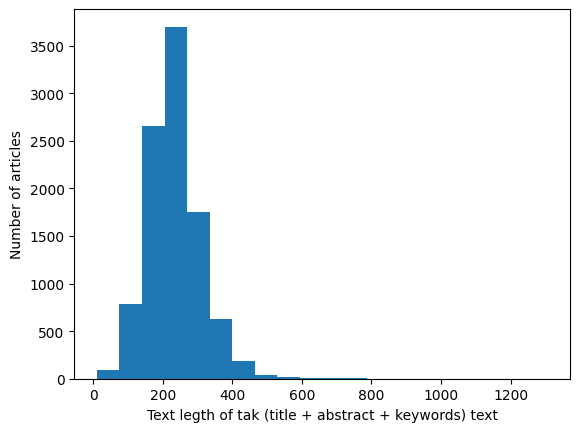

In [10]:
# Distribution of text length in the title + keywords + abstract
input_path = fpath.poten_litera_db
df = pd.read_csv(input_path, header=None, sep=',')
df.columns = [
    "INDEX", "DOI", "PMID", "PMCID", "FULL_TEXT_URL", "FULL_TEXT_SOURCE", "PDF_URL", "PDF_SOURCE", 
    "TITLE", "ABSTRACT", "KEYWORDS"
    ]

len_list = []

for ind in df.index:
    text = ""
    num_words = 0

    if df.at[ind, "ABSTRACT"] == df.at[ind, "ABSTRACT"]: # if abstract is available
        abstract = df.at[ind, "ABSTRACT"]
    else: # skip this article if abstract is not available
        continue
    if df.at[ind, "TITLE"] == df.at[ind, "TITLE"]:
        title = df.at[ind, "TITLE"]
    else:
        title = ""
    if df.at[ind, "KEYWORDS"] == df.at[ind, "KEYWORDS"]:
        keywords = df.at[ind, "KEYWORDS"]
    else:
        keywords = ""

    text = title + " " + abstract + " " + keywords
    
    # process the text
    text = plib.process_text(text, lower=True)

    num_words = len(text.split())

    len_list.append(num_words)

# calculate the average and maximum number of words in the text
print("The number of articles considered:", len(len_list))
print("Max of length:", max(len_list))
print("Average length:", np.mean(len_list))
print("Median length:", np.median(len_list))
print("Std of length:", np.std(len_list))

# sort the len_list and draw a histogram
len_list.sort()
plt.hist(len_list, bins=20)
plt.xlabel("Text legth of tak (title + abstract + keywords) text")
plt.ylabel("Number of articles")
plt.show()
# The number of articles considered: 9892
# Max of length: 1307
# Average length: 235.13121714516782
# Median length: 230.0
# Std of length: 79.72543466983504

In [11]:
# process the train_test_1000 set, extract sentences and counts, save to poten_litera_testing_set_1000_text_extract_and_count
input_path = fpath.poten_litera_testing_set_1000
db_path = fpath.poten_litera_db
output_path = fpath.poten_litera_testing_set_1000_text_extract_and_count
# clear the file
plib.clear_file(output_path)

extract_sents_and_record(input_path, db_path, output_path)

In [12]:
# # read the db_final.csv and scan the rows and count the number of np.nans in the columns Macaque?(Y/N), Thalamus?(Y/N), Inject?(Y/N)
# input_path = fpath.poten_litera_db_text_extract
# df = pd.read_csv(input_path, header=0, sep=',')
# df.columns = ["INDEX", "DOI", "PMID", "PMCID", "FULL_TEXT_URL", "FULL_TEXT_SOURCE", "PDF_URL", "PDF_SOURCE", 
#                "TITLE", "ABSTRACT", "KEYWORDS", 
#                "SPIECIES_TEXT", "THALAM_TEXT", "INJECT_TEXT", 
#                "Macaque?(Y/N)", "Thalamus?(Y/N)", "Inject?(Y/N)"]

# macaque = 0
# thalamus = 0
# inject = 0

# for ind in df.index:
#     if df.at[ind, "SPIECIES_TEXT"] != df.at[ind, "SPIECIES_TEXT"]:
#         macaque += 1
#         print("No macaque in text!")
#         print(df.at[ind, "INDEX"])
#         print(df.at[ind, "FULL_TEXT_URL"])
#         print("\n")
#     if df.at[ind, "THALAM_TEXT"] != df.at[ind, "THALAM_TEXT"]:
#         thalamus += 1
#         print("No thalamus in text!")
#         print(df.at[ind, "INDEX"])
#         print(df.at[ind, "FULL_TEXT_URL"])
#         print("\n")
#     if df.at[ind, "INJECT_TEXT"] != df.at[ind, "INJECT_TEXT"]:
#         inject += 1

# print("Macaque:", macaque)
# print("Thalamus:", thalamus)
# print("Inject:", inject)

In [13]:
# read from poten_litera_db, count keywords, save to poten_litera_db_kw_count
input_path = fpath.poten_litera_db
output_path = fpath.poten_litera_db_kw_count

# clear file
plib.clear_file(output_path)

count_and_record_db(input_path, output_path, params.ranking_kw_groups)

In [14]:
# read from poten_litera_db_kw_count, rank the candidate articles, save to poten_litera_db_ranked
input_path = fpath.poten_litera_db_kw_count
output_path = fpath.poten_litera_db_ranked

# clear file
plib.clear_file(output_path)

rank(input_path, output_path, params.ranking_kw_groups_weights)

ValueError: Length mismatch: Expected axis has 14 elements, new values have 11 elements

#### 2. Ranking results analysis

In [ ]:
# # read the ranked database and obtain the relevance_index of YESs and NOs 
# # of the test data set and draw a violin plot, and calculate the difference between the two distributions
# # the difference is defined as 1. t-statistic 2. 
# db_ranked_path = fpath.poten_litera_db_ranked
# test_path = fpath.poten_litera_testing_set_1000_read

# df_db_ranked = pd.read_csv(db_ranked_path, header=0, sep=',')
# df_db_ranked.columns = [
#     "INDEX", "DOI", "PMID", "PMCID", "FULL_TEXT_URL", "FULL_TEXT_SOURCE", "PDF_URL", "PDF_SOURCE", 
#     "TITLE", "ABSTRACT", "KEYWORDS", 
#     "SPECIES_RELATED", "TC_CT_RELATED", "THALAM_RELATED", "CORTEX_RELATED", "METHOD_RELATED", "CONNECTIVITY_RELATED",
#     "RELEVANCE_INDEX"]

# df_test = pd.read_csv(test_path, header=0, sep=',')
# df_test.columns = ["INDEX", "DOI", "PMID", "PMCID", "FULL_TEXT_URL", "FULL_TEXT_SOURCE", "PDF_URL", "PDF_SOURCE", "TITLE", "ABSTRACT", "KEYWORDS", "RELEVANT"]

In [ ]:
# # save the counts of the keywords in the respective lists
# relevant_species = []
# relevant_tc_ct = []
# relevant_thalam = []
# relevant_cortex = []
# relevant_method = []
# relevant_connectivity = []

# non_relevant_species = []
# non_relevant_tc_ct = []
# non_relevant_thalam = []
# non_relevant_cortex = []
# non_relevant_method = []
# non_relevant_connectivity = []

# relvant_index = []
# relevant_relevance_index_list = []

# non_relevant_index = []
# non_relevant_relevance_index_list = []

# for ind in df_test.index:
#     index = int(df_test.at[ind, "INDEX"])
#     # print(ind, index)
#     # print(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "RELEVANCE_INDEX"].values[0])

#     # if df_test.at[ind, "RELEVANT"] == "YES" and df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "LENGTH_TEXT"].values[0] > 100:
#     if df_test.at[ind, "RELEVANT"] == "YES":
#         relvant_index.append(index)
#         relevant_relevance_index_list.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "RELEVANCE_INDEX"].values[0])
#         relevant_species.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "SPECIES_RELATED"].values[0])
#         relevant_tc_ct.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "TC_CT_RELATED"].values[0])
#         relevant_thalam.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "THALAM_RELATED"].values[0])
#         relevant_cortex.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "CORTEX_RELATED"].values[0])
#         relevant_method.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "METHOD_RELATED"].values[0])
#         relevant_connectivity.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "CONNECTIVITY_RELATED"].values[0])
#     # elif df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "LENGTH_TEXT"].values[0] > 100:
#     else:
#         non_relevant_index.append(index)
#         non_relevant_relevance_index_list.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "RELEVANCE_INDEX"].values[0])
#         non_relevant_species.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "SPECIES_RELATED"].values[0])
#         non_relevant_tc_ct.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "TC_CT_RELATED"].values[0])
#         non_relevant_thalam.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "THALAM_RELATED"].values[0])
#         non_relevant_cortex.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "CORTEX_RELATED"].values[0])
#         non_relevant_method.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "METHOD_RELATED"].values[0])
#         non_relevant_connectivity.append(df_db_ranked.loc[df_db_ranked["INDEX"].apply(int) == index, "CONNECTIVITY_RELATED"].values[0])

In [ ]:
# for i in range(len(relvant_index)):
#     print(relvant_index[i], relevant_relevance_index_list[i])
#     # print(relevant_relevance_index_list)

In [ ]:
# # plot the dot plot of the relevance_index of YESs and NOs of the test data set
# plt.figure(figsize=(10, 5))
# plt.plot(relvant_index, relevant_relevance_index_list, 'ro', label="YES")
# plt.plot(non_relevant_index, non_relevant_relevance_index_list, 'bo', label="NO")
# plt.xlabel("Index")
# plt.ylabel("Relevance Index")
# plt.legend()

# # add labels for the relevant index points
# for i, index in enumerate(relvant_index):
#     plt.text(index, relevant_relevance_index_list[i]+0.1, str(index), color='black', fontsize=10)

# # # add labels for the relevant index points
# # for i, index in enumerate(non_relevant_index):
# #     plt.text(index, non_relevant_relevance_index_list[i], str(index), color='black', fontsize=10)

# plt.show()

In [ ]:
# # plot the 6 dot plots of the species_related, tc_ct_related, thalam_related, cortex_related, method_related, connectivity_related of YESs and NOs of the test data set in 2 rows in the same figure
# plt.figure(figsize=(10, 10))
# plt.subplot(3, 2, 1)
# plt.plot(relvant_index, relevant_species, 'ro', label="YES")
# plt.plot(non_relevant_index, non_relevant_species, 'bo', label="NO")
# plt.xlabel("Index")
# plt.ylabel("Species Related")
# plt.legend()

# plt.subplot(3, 2, 2)
# plt.plot(relvant_index, relevant_tc_ct, 'ro', label="YES")
# plt.plot(non_relevant_index, non_relevant_tc_ct, 'bo', label="NO")
# plt.xlabel("Index")
# plt.ylabel("TC_CT Related")
# plt.legend()

# plt.subplot(3, 2, 3)
# plt.plot(relvant_index, relevant_thalam, 'ro', label="YES")
# plt.plot(non_relevant_index, non_relevant_thalam, 'bo', label="NO")
# plt.xlabel("Index")
# plt.ylabel("Thalam Related")
# plt.legend()

# plt.subplot(3, 2, 4)
# plt.plot(relvant_index, relevant_cortex, 'ro', label="YES")
# plt.plot(non_relevant_index, non_relevant_cortex, 'bo', label="NO")
# plt.xlabel("Index")
# plt.ylabel("Cortex Related")
# plt.legend()

# plt.subplot(3, 2, 5)
# plt.plot(relvant_index, relevant_method, 'ro', label="YES")
# plt.plot(non_relevant_index, non_relevant_method, 'bo', label="NO")
# plt.xlabel("Index")
# plt.ylabel("Method Related")
# plt.legend()

# plt.subplot(3, 2, 6)
# plt.plot(relvant_index, relevant_connectivity, 'ro', label="YES")
# plt.plot(non_relevant_index, non_relevant_connectivity, 'bo', label="NO")
# plt.xlabel("Index")
# plt.ylabel("Connectivity Related")
# plt.legend()

# plt.show()


In [ ]:
# def pick_values_uniformly(data, n):
#     """Pick up `n` values uniformly from `data`."""
#     if n <= 0:
#         return []

#     # Determine the range of the data
#     min_val, max_val = min(data), max(data)

#     threshold = (max_val - min_val) / n / 2

#     # If n is 1, just return the midpoint
#     if n == 1:
#         return [(min_val + max_val) / 2]

#     # Calculate the interval size
#     interval = (max_val - min_val) / (n - 1)

#     # Get the uniform values
#     return [min_val + i * interval for i in range(n)], threshold

# # data = [1, 3, 5, 2, 8, 10, 2]
# n = 5
# density_display_index, thres = pick_values_uniformly(relevant_relevance_index_list + non_relevant_relevance_index_list, n)
# print(density_display_index)

In [ ]:
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Printing the length of lists
# print("Numer of relevant literature:", len(relevant_relevance_index_list))
# print("Number of not relevant literature:", len(non_relevant_relevance_index_list))
# print()

# # Create a DataFrame for plotting
# df = pd.DataFrame({'Relevance Index': relevant_relevance_index_list + non_relevant_relevance_index_list, 
#                    'Label': ['Relevant'] * len(relevant_relevance_index_list) + ['Not Relevant'] * len(non_relevant_relevance_index_list)})

# # Draw the violin plot
# plt.figure(figsize=(10, 6))
# ax = sns.violinplot(x='Label', y='Relevance Index', data=df, bw='scott', cut=0)

# relevance_indices = density_display_index  # Replace with your relevance indices

# threshold = thres  # Adjust this based on your desired range around the relevance index

# for index in relevance_indices:
#     ax.axhline(index, color='gray', linestyle='--')
    
#     for i, label in enumerate(df['Label'].unique()):
#         # Filter data points close to the current relevance index
#         close_points = df[(df['Label'] == label) & (np.abs(df['Relevance Index'] - index) < threshold)]
#         density = len(close_points)
        
#         ax.text(i, index + 0.1, str(density), ha='center', va='center', color='red', fontsize=9)  # adjust the vertical offset (0.1 here) as necessary

# plt.title('Distribution of Relevance Index')
# plt.show()

In [ ]:
# import scipy.stats as stats

# # Check the equality of variances
# var_relevant = np.var(relevant_relevance_index_list)
# var_non_relevant = np.var(non_relevant_relevance_index_list)
# print('Variance of relevant:', var_relevant)
# print('Variance of non-relevant:', var_non_relevant)
# print(var_relevant/var_non_relevant)
# # statistic, p_value = stats.levene(relevant_relevance_index_list, non_relevant_relevance_index_list)

# # # Print the results
# # print('Levene test statistic:', statistic)
# # print('p-value:', p_value)

In [ ]:
# # Calculate the t-statistic and p-value
# t_statistic, p_value = stats.ttest_ind(relevant_relevance_index_list, non_relevant_relevance_index_list)

# # Print the results
# print('t-statistic:', t_statistic)
# print('p-value:', p_value)

<h3> Next step: manually read papers and find all actually related literature </h3>